In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

In [2]:
# Nicer plotting
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = (8,4)

# Autophase and Autophase and Scale examples

In [3]:
from impact import Impact, template_dir

import numpy as np
import os

In [4]:
ifile = os.path.join(template_dir,'lcls_injector/ImpactT.in')
os.path.exists(ifile)

True

In [5]:
# Make Impact object
I = Impact(ifile, verbose=True)

================ Impact-T Summary ================    
10000 particles
1 bunch of electrons
total charge: 249.99999999999997 pC
Distribution type: read
Cathode start at z = 0 m
   emission time: 1.4e-11 s
   image charges neglected after z = 0.02 m
Processor domain: 1 x 1 = 1 CPUs
Space charge grid: 16 x 16 x 16
Maximum time steps: 1000000
Reference Frequency: 2856000000.0 Hz
Initial reference time: 0.0 s
Simulation starting from the beginning

Configured to run in: /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmp33f3pg_q


# Phase and Scale the LCLS gun

In [6]:
from impact.autophase import autophase_and_scale

from pmd_beamphysics import single_particle

P0 = single_particle(pz=1e-15, z=1e-15)

In [7]:
autophase_and_scale(I, phase_ele_name='GUN', target=6e6, scale_range=(10e6, 100e6), initial_particles=P0, verbose=True)

Copied initial Impact object. 
Phasing GUN by changing theta0_deg
Scaling GUN by changing rf_field_scale
Bounds: 0.0, 0.15 m
Disabling SOL1
Disabling L0A_entrance
Disabling L0A_body_1
Disabling L0A_body_2
Disabling L0A_exit
Disabling L0B_entrance
Disabling L0B_body_1
Disabling L0B_body_2
Disabling L0B_exit
Default brent2 algorithm
Phase: 180, Scale: 55000000.0, 0.0 M
Phase: 180, Scale: 55000000.0, 0.0 M
Phase: 42.49224000000004, Scale: 55000000.0, 0.0 M
Phase: 180, Scale: 55000000.0, 0.0 M
Phase: 42.49223094384001, Scale: 55000000.0, 0.0 M
Phase: 179.9999944029853, Scale: 55000000.0, 0.0 M
Phase: 264.9844674846946, Scale: 55000000.0, 0.0 M
Phase: 317.5077613212758, Scale: 55000000.0, 6.789068290178669 MeV
Phase: 349.96894270427333, Scale: 55000000.0, 5.330287308745045 MeV
Phase: 322.77625848484456, Scale: 55000000.0, 6.681320604655166 MeV
Phase: 308.7869043171082, Scale: 55000000.0, 6.8708903075727115 MeV
Phase: 307.2184724074964, Scale: 55000000.0, 6.873948115480826 MeV
Phase: 306.551

(303.92149543274877, 47537662.63920119)

In [8]:
# Check this:
I.verbose=False
PF = I.track(P0, s=0.15)
PF['mean_energy']

6000000.055065957

In [9]:
# Examine this process using the debug flag. This will return the function used for phasing and scaling. 
ps_f, Itest = autophase_and_scale(I, phase_ele_name='GUN', target=6e6, initial_particles=P0, verbose=False,
                     debug = True)


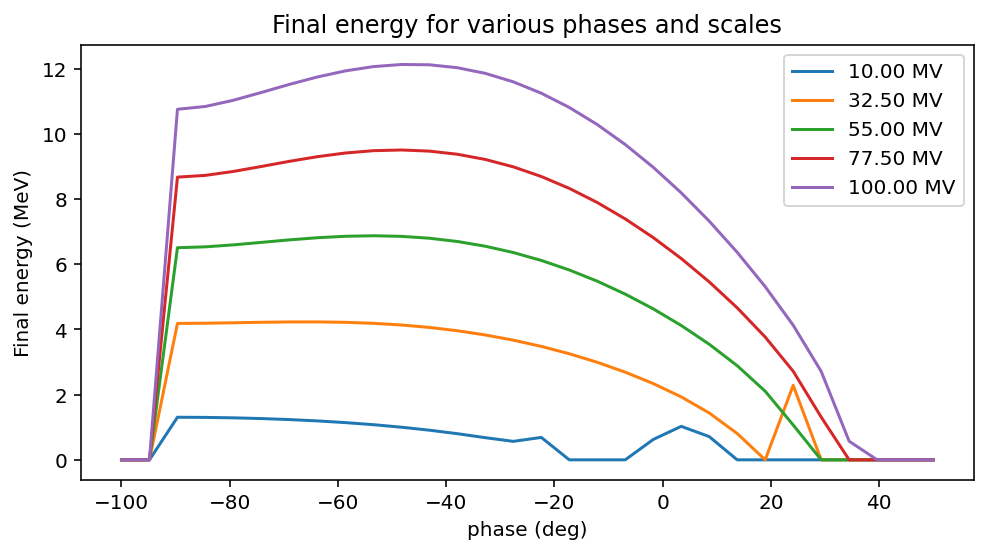

In [10]:
# Phases to try
ptry = np.linspace(-100, 50, 30)

# scales to try
for sc in np.linspace(10e6, 100e6, 5):
    res = np.array([ps_f(p, sc)/1e6 for p in ptry])
    plt.plot(ptry, res, label=f'{sc/1e6:0.2f} MV')
plt.title('Final energy for various phases and scales')
plt.ylabel('Final energy (MeV)')
plt.xlabel('phase (deg)')
plt.legend()

In [11]:
# 3D plot

# Make data.
X = np.linspace(-100, 50, 10)
Y = np.linspace(10e6, 100e6, 10)
X, Y = np.meshgrid(X, Y)
@np.vectorize
def f(phase, scale):
    return ps_f(phase, scale)
Z = f(X, Y)

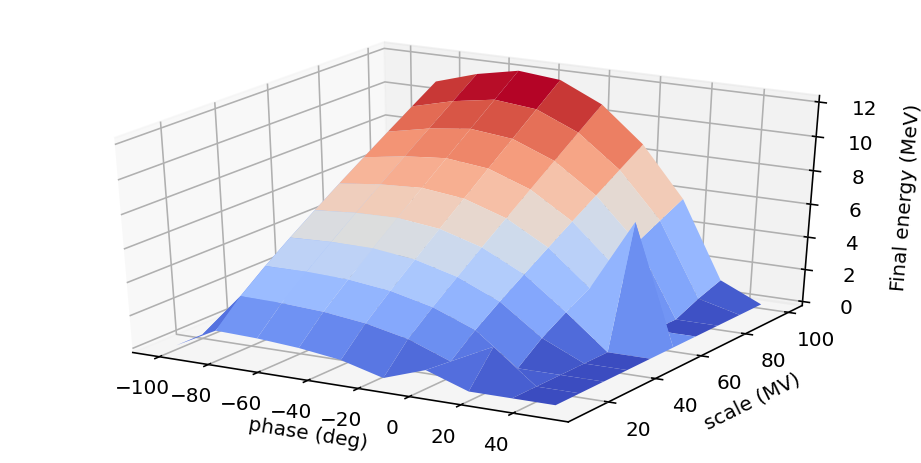

In [12]:
# Plot the surface.
fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(X, Y/1e6, Z/1e6, cmap=matplotlib.cm.coolwarm,
                       linewidth=0, antialiased=True)

# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_xlabel('phase (deg)')
ax.set_ylabel('scale (MV)')
ax.set_zlabel('Final energy (MeV)')
plt.show()



# Phase and scale LCLS linac sections 

Linacs L0A and L0B are special, because they require 4 fieldmaps each to model the travelling wave structure. To tune these together, we need to add control groups

In [13]:
#  Changes in phases
I.add_group('L0A', ele_names=['L0A_entrance', 'L0A_body_1', 'L0A_body_2', 'L0A_exit'], var_name='theta0_deg', attributes='theta0_deg')
I.add_group('L0B', ele_names=['L0B_entrance', 'L0B_body_1', 'L0B_body_2', 'L0B_exit'], var_name='theta0_deg', attributes='theta0_deg')

# Overall scaling, respecting the special factors. 
I.add_group('L0A_scale', ele_names=['L0A_entrance', 'L0A_body_1', 'L0A_body_2', 'L0A_exit'],
                   var_name = 'rf_field_scale',
                  factors = [0.86571945106805, 1, 1, 0.86571945106805],  # sin(k*d) with d = 3.5e-2 m 
                  absolute=True)

# Overall scaling, respecting the special factors. 
I.add_group('L0B_scale', ele_names=['L0B_entrance', 'L0B_body_1', 'L0B_body_2', 'L0B_exit'],
                   var_name = 'rf_field_scale',
                  factors = [0.86571945106805, 1, 1, 0.86571945106805],  # sin(k*d) with d = 3.5e-2 m 
                  absolute=True)

I['L0A_scale']['rf_field_scale'] = 30e6
I['L0A_scale']



ControlGroup(**{"ele_names": ["L0A_entrance", "L0A_body_1", "L0A_body_2", "L0A_exit"], "var_name": "rf_field_scale", "attributes": ["rf_field_scale", "rf_field_scale", "rf_field_scale", "rf_field_scale"], "factors": [0.86571945106805, 1, 1, 0.86571945106805], "absolute": true, "value": 30000000.0})

In [14]:
# L0A to 64 MeV

autophase_and_scale(I, phase_ele_name='L0A', scale_ele_name='L0A_scale', target=64e6, scale_range=(10e6, 100e6), initial_particles=P0, verbose=True)

Copied initial Impact object. 
Phasing L0A by changing theta0_deg
Scaling L0A_scale by changing rf_field_scale
Bounds: 1.485, 4.527856 m
Tracking initial particles to s = 1.485
Initial particle:  1.48506151087 6000000.055065957
Disabling GUN
Disabling SOL1
Disabling L0B_entrance
Disabling L0B_body_1
Disabling L0B_body_2
Disabling L0B_exit
Default brent2 algorithm
Phase: 180, Scale: 55000000.0, 92.19549870606345 MeV
Phase: 180, Scale: 55000000.0, 92.19549870606345 MeV
Phase: 42.49224000000004, Scale: 55000000.0, 95.45266468239531 MeV
Phase: 264.9844890561601, Scale: 55000000.0, 28.14918539632568 MeV
Phase: 42.49224000000004, Scale: 55000000.0, 95.45266468239531 MeV
Phase: 42.49223440298533, Scale: 55000000.0, 95.45267036417847 MeV
Phase: 264.9844709438398, Scale: 55000000.0, 28.149206441255405 MeV
Phase: 222.49225239715815, Scale: 55000000.0, 87.41809553397265 MeV
Phase: 127.47670402554945, Scale: 55000000.0, 90.18262694866212 MeV
Phase: 333.73836127614754, Scale: 55000000.0, 91.9254181

(8.97658249933529, 30048347.466270827)

In [15]:
autophase_and_scale(I, phase_ele_name='L0B', scale_ele_name='L0B_scale', target=135e6, scale_range=(10e6, 100e6), initial_particles=P0, verbose=True)

Copied initial Impact object. 
Phasing L0B by changing theta0_deg
Scaling L0B_scale by changing rf_field_scale
Bounds: 5.328756, 8.371612 m
Tracking initial particles to s = 5.328756
Initial particle:  5.32873090575 63999929.3562537
Disabling GUN
Disabling SOL1
Disabling L0A_entrance
Disabling L0A_body_1
Disabling L0A_body_2
Disabling L0A_exit
Default brent2 algorithm
Phase: 180, Scale: 55000000.0, 42.79528261146795 MeV
Phase: 180, Scale: 55000000.0, 42.79528261146795 MeV
Phase: 42.49224000000004, Scale: 55000000.0, 146.83351252025167 MeV
Phase: 264.9844890561601, Scale: 55000000.0, 47.97388293022323 MeV
Phase: 42.49224000000004, Scale: 55000000.0, 146.83351252025167 MeV
Phase: 42.49223440298533, Scale: 55000000.0, 146.83351901150888 MeV
Phase: 264.9844709438398, Scale: 55000000.0, 47.97384990773428 MeV
Phase: 222.49224902053152, Scale: 55000000.0, 18.42709890653062 MeV
Phase: 127.47670402554945, Scale: 55000000.0, 4.2325007724433386 MeV
Phase: 333.73835998639106, Scale: 55000000.0, 15

(3.765128924156072, 36780527.329403125)

In [16]:
I.track(P0, s=8.371612)['mean_energy']

134999242.14345512

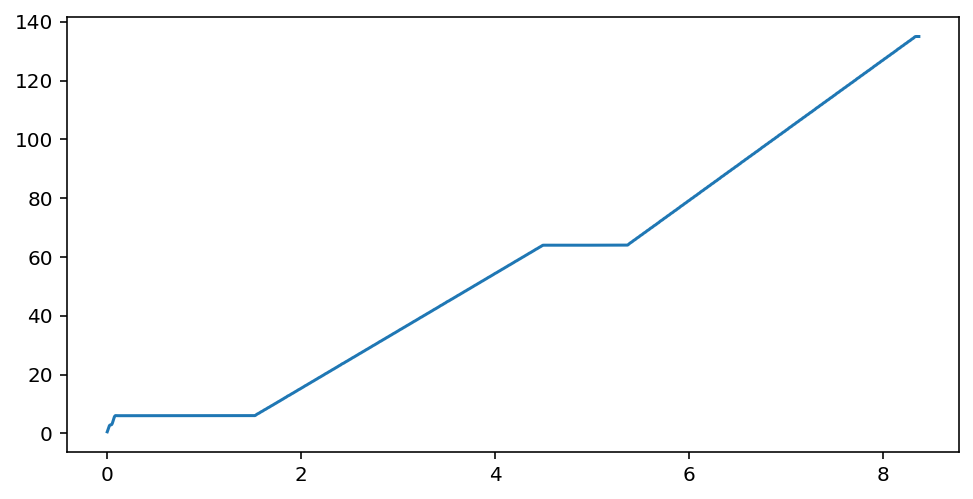

In [17]:
plt.plot(I.stat('mean_z'), I.stat('mean_kinetic_energy')/1e6 + 0.511)

# Autophase without scaling

Just phasing is simpler.

In [18]:
from impact.autophase import autophase


ifile2 = os.path.join(template_dir,'apex_gun/ImpactT.in')

I2 = Impact(ifile2, verbose=False)

In [19]:
autophase(I2, ele_name='APEX_GUN', initial_particles=P0, metric='mean_kinetic_energy', verbose=True)

Copied initial Impact object. 
Phasing APEX_GUN by changing theta0_deg
Bounds: 0.0, 0.199 m
Default brent2 algorithm
Phase: 180, 0.7501400260547707 MeV
Phase: 180, 0.7501400260547707 MeV
Phase: 42.49224000000004, 0.0 M
Phase: 180, 0.7501400260547707 MeV
Phase: 42.49223094384001, 0.0 M
Phase: 42.49223999999998, 0.0 M
Phase: 222.49223547192, 0.4648792164992943 MeV
Phase: 151.59398241178104, 0.714711059468071 MeV
Phase: 171.3511003792883, 0.7585459504017038 MeV
Phase: 171.34908462106745, 0.7585459029872261 MeV
Phase: 171.4523027473299, 0.7585471358806966 MeV
Phase: 171.45289970740637, 0.7585471359181192 MeV
Phase: 171.45272825449666, 0.7585471359181192 MeV
Phase: 171.45255680175842, 0.7585471359087637 MeV
Set Phase: 171.45272825449666


171.45272825449666

In [20]:
phase_f, Itest = autophase(I2, ele_name='APEX_GUN', metric='mean_kinetic_energy', initial_particles=P0, debug = True)

Text(0.5, 0, 'phase (deg)')

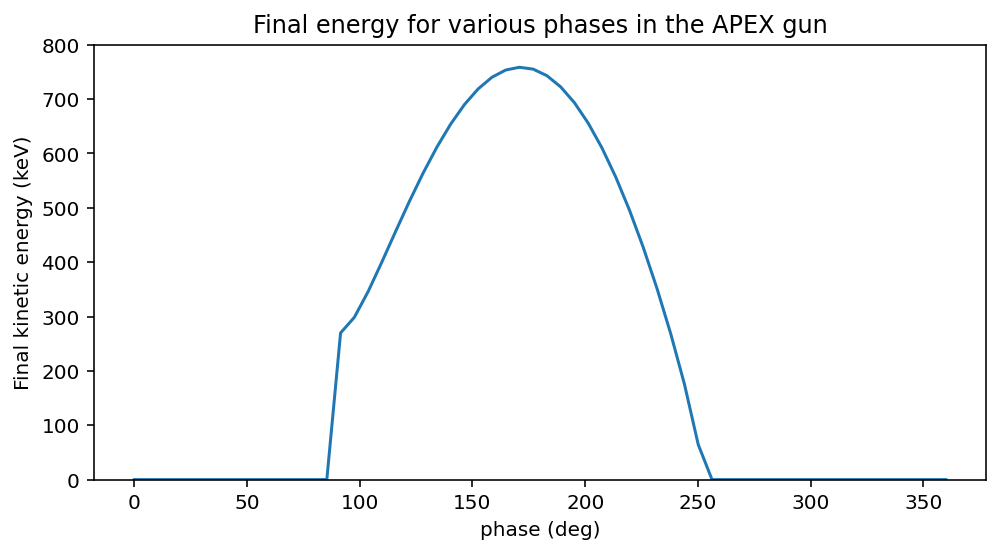

In [21]:
# Phases to try
ptry = np.linspace(0, 360, 60)

energies = np.array([phase_f(p)/1e3 for p in ptry]) 

plt.plot(ptry, energies)
plt.ylim(0, 800)
plt.title('Final energy for various phases in the APEX gun')
plt.ylabel('Final kinetic energy (keV)')
plt.xlabel('phase (deg)')
